In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os 
import pandas as pd 
import pickle 
import random 
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

## Dataset info

Dataset is available at https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/1ECTVN

Our dataset contains 5 different types of flowers having 600-800 images for each type :
1. daisy
2. dandelion 
3. roses 
4. sunflowers
5. tulips

## Looking around the data

In [2]:
os.listdir("./flowers/flower_photos")

['.DS_Store', 'test', 'train', 'validation']

So we already have 3 different subsets for train, test and validation !

In [3]:
os.listdir("./flowers/flower_photos/train")

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [4]:
print("Number of images per flower type")
for class_name in os.listdir("./flowers/flower_photos/train"):
    class_path = os.path.join("./flowers/flower_photos/train", class_name)
    print(f"{class_name}:{len(os.listdir(class_path))}")

Number of images per flower type
daisy:607
dandelion:872
roses:615
sunflowers:673
tulips:773


### Just looking at one sample image

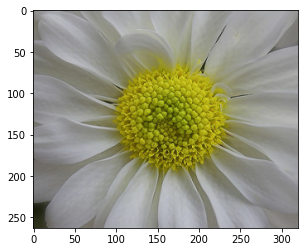

In [5]:
img = cv2.imread("./flowers/flower_photos/train/daisy/100080576_f52e8ee070_n.jpg", 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [6]:
img.shape

(263, 320, 3)

## Let's load the data 

In [7]:
train_dir = "./flowers/flower_photos/train"
test_dir = "./flowers/flower_photos/test"
valid_dir = "./flowers/flower_photos/validation"
classes = os.listdir(train_dir) # store classes of flowers

In [8]:
def load_data(dir):
    X = []
    y = []
    for class_name in os.listdir(dir):
        class_id = classes.index(class_name)
        class_path = os.path.join(dir, class_name)
        for img_name in tqdm(os.listdir(class_path)) :
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224,224))
            img = np.array(img)
            X.append(img)
            y.append(class_id)
    return np.array(X), np.array(y) 

In [9]:
X_train, y_train = load_data(train_dir)

100%|███████████████████████████████████████████████████████████████████████████████| 773/773 [00:02<00:00, 293.19it/s]


In [10]:
X_valid, y_valid = load_data(valid_dir)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 82.17it/s]


In [11]:
X_test, y_test = load_data(test_dir)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 73.53it/s]


In [12]:
X_train.shape

(3540, 224, 224, 3)

In [13]:
y_train.shape

(3540,)

### Converting target values to categories 

like if y1 = 0, y2 = 1, ...y5 = 4 
so our y1 will be [1,0,0,0,0],  y2 will be [0,1,0,0,0] , ...

In [14]:
y_train = tf.keras.utils.to_categorical(y_train)
y_valid = tf.keras.utils.to_categorical(y_valid)
y_test = tf.keras.utils.to_categorical(y_test)

In [15]:
y_train.shape

(3540, 5)

In [16]:
y_valid.shape

(80, 5)

### Shuffling data 

In [17]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test  = shuffle(X_test, y_test)

### Let's just visualize some flowers 
just to make sure everything is correct

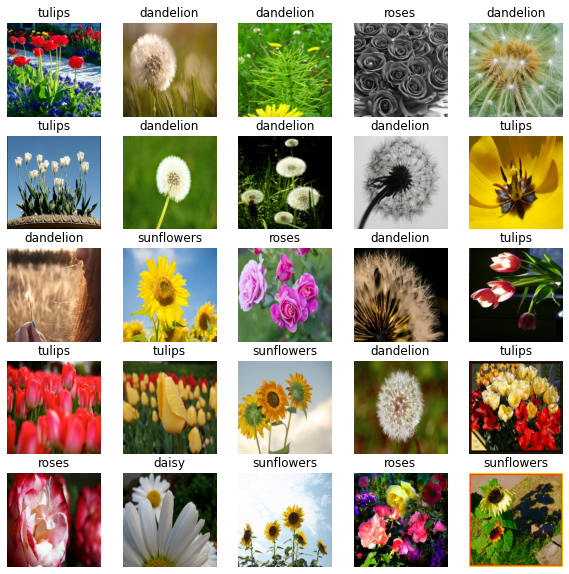

In [18]:
fig, axes = plt.subplots(5,5, figsize=(10,10))
axes = axes.flatten()

for ax in axes :
    i = np.random.randint(0,3000)
    img = X_train[i,:,:,:]
    label = classes[np.argmax(y_train[i,:])]
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")

## Model creation

In [30]:
def create_model() : 
    base_model = tf.keras.applications.mobilenet.MobileNet(
        input_shape = (224,224,3), include_top=False, weights='imagenet'
    )
    base_model.trainable = False
    model = Sequential(base_model, name="MobileNet")
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(256))
    model.add(Dense(64))
    model.add(Dense(len(classes) , activation="softmax"))
    return model

In [31]:
model = create_model()

In [32]:
model.summary()

Model: "MobileNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               25690624  
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 325       
Total params: 29,067,589
Trainable params: 25,838,725
Non-trainable params: 3,228,864
_____________________________________

In [33]:
model.compile(
    optimizer="Adam", 
    loss="categorical_crossentropy",
    metrics = ["accuracy"]
)

In [34]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data = (X_valid, y_valid)
)

Epoch 1/20
111/111 [==============================] - 159s 1s/step - loss: 81.8964 - accuracy: 0.4099 - val_loss: 1.5050 - val_accuracy: 0.6500
Epoch 2/20
111/111 [==============================] - 141s 1s/step - loss: 0.9973 - accuracy: 0.7439 - val_loss: 1.5031 - val_accuracy: 0.6750
Epoch 3/20
111/111 [==============================] - 129s 1s/step - loss: 0.5064 - accuracy: 0.8537 - val_loss: 2.9067 - val_accuracy: 0.6250
Epoch 4/20
111/111 [==============================] - 129s 1s/step - loss: 0.3747 - accuracy: 0.8976 - val_loss: 2.5121 - val_accuracy: 0.7375
Epoch 5/20
111/111 [==============================] - 139s 1s/step - loss: 0.3298 - accuracy: 0.9098 - val_loss: 3.0375 - val_accuracy: 0.5750
Epoch 6/20
111/111 [==============================] - 140s 1s/step - loss: 0.2576 - accuracy: 0.9271 - val_loss: 3.5032 - val_accuracy: 0.6625
Epoch 7/20
111/111 [==============================] - 140s 1s/step - loss: 0.1897 - accuracy: 0.9588 - val_loss: 3.3255 - val_accuracy: 0.687

KeyboardInterrupt: 

In [35]:
model.save("model.h5")